In [1]:
from vnstock import *
from function import *
from operators import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

##### VN30

In [18]:
x='2023-02-14'
ticket = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'POW', 'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']
frame = []
for i in ticket:
    a = stock_historical_data(symbol=i, 
                            start_date="2013-01-01", 
                            end_date=x)    
    a["ticker"] = i
    frame.append(a)
    
q = pd.concat(frame)
close= q.pivot_table(values="Close", columns="ticker", index="TradingDate")
high= q.pivot_table(values="High", columns="ticker", index="TradingDate")
low= q.pivot_table(values="Low", columns="ticker", index="TradingDate")
open= q.pivot_table(values="Open", columns="ticker", index="TradingDate")
volume = q.pivot_table(values="Volume", columns="ticker", index="TradingDate")

In [9]:
close= close.to_csv("Data/close.csv",mode="a",header=False)
high= high.to_csv("Data/high.csv",mode="a",header=False)
low= low.to_csv("Data/low.csv",mode="a",header=False)
open= open.to_csv("Data/open.csv",mode="a",header=False)
volume= volume.to_csv("Data/open.csv",mode="a",header=False)

In [7]:
close= pd.read_csv("Data/close.csv",index_col="TradingDate")
close.index = pd.to_datetime(close.index)
high= pd.read_csv("Data/high.csv",index_col="TradingDate")
high.index = pd.to_datetime(high.index)
low= pd.read_csv("Data/low.csv",index_col="TradingDate")
low.index = pd.to_datetime(low.index)
open= pd.read_csv("Data/open.csv",index_col="TradingDate")
open.index = pd.to_datetime(open.index)
volume= pd.read_csv("Data/volume.csv",index_col="TradingDate")
volume.index = pd.to_datetime(open.index)

returns = close.pct_change()

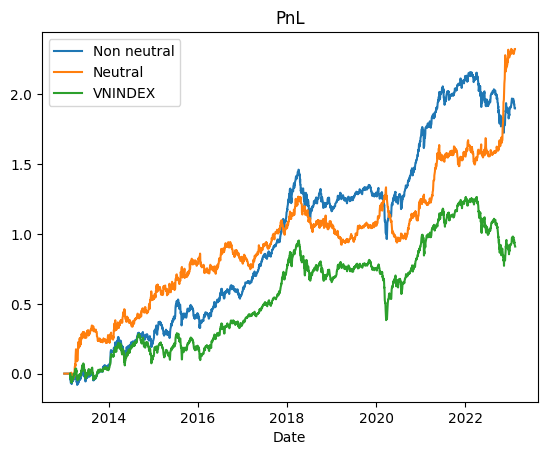

In [17]:
w = weights(prob_weights(close,30),neutrali=0)
w1 = weights(prob_weights(close,30),neutrali=1)

a = Simresult(w,returns=returns)
a.plot_pnl("Non neutral")

b = Simresult(w1,returns=returns)
b.plot_pnl("Neutral")

plot_vnindex()

In [21]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.232279,1.170304,0.514758,0.786144,451.238751


In [19]:
b.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,0.264529,1.332953,0.429612,1.045956,615.739626
2014,0.272199,1.294426,0.484901,0.969827,561.350206
2015,0.260487,1.246051,0.521277,0.880835,499.709887
2016,0.018922,0.106423,0.492975,0.020850,38.382613
2017,0.249012,1.716845,0.500039,1.211545,497.985248
2018,0.004135,0.018481,0.543591,0.001612,7.607266
2019,0.021165,0.171802,0.532422,0.034254,39.751452
2020,0.171924,0.866309,0.552328,0.483330,311.272548
2021,0.311681,1.565907,0.495535,1.241892,628.978358


In [20]:
w1.iloc[-1,:].sort_values(ascending=False)

PLX    0.170114
VCB    0.144716
BCM    0.093838
BID    0.079223
SAB    0.068606
VRE    0.060373
GAS    0.057783
HDB    0.055720
FPT    0.054698
POW    0.047177
HPG    0.046861
VIB    0.042554
CTG    0.026624
ACB    0.023481
TPB    0.020179
STB    0.008052
BVH   -0.005625
MBB   -0.007485
SSI   -0.017109
GVR   -0.041896
VNM   -0.043423
MSN   -0.047685
TCB   -0.064336
VIC   -0.067592
MWG   -0.093494
VPB   -0.100967
VJC   -0.113822
PDR   -0.115360
NVL   -0.126237
VHM   -0.154970
Name: 2023-02-13 00:00:00, dtype: float64

### Markowitz model

In [112]:
lag=10
w = pd.DataFrame(np.nan, index=close.index  , columns=close.columns)
for i in range(int(len(close)/lag)):
    w.iloc[(i+1)*lag,:] = marko_weights(close[i*lag:(i+1)*lag])
w.ffill(inplace=True)  

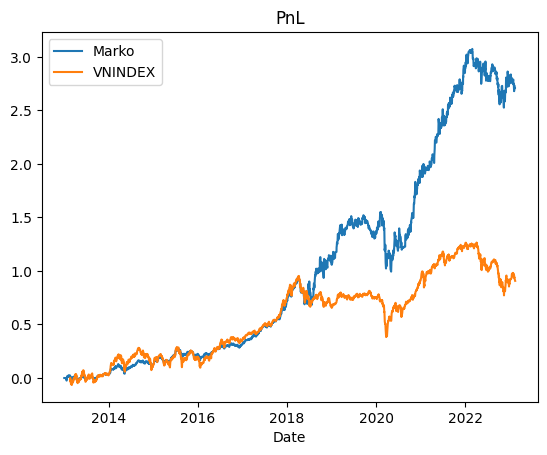

In [113]:
a = Simresult(w,returns=close.pct_change())
a.plot_pnl("Marko")

plot_vnindex()

In [107]:
w.iloc[-1,:].sort_values(ascending=False)

VCB    1.000000e+00
NVL    5.833212e-16
PLX    5.012560e-16
VIB    4.432995e-16
POW    4.278986e-16
MSN    3.215095e-16
SAB    2.900213e-16
MWG    2.266368e-16
FPT    2.230720e-16
VHM    1.655467e-16
VIC    1.044592e-16
GAS    7.632670e-17
HDB    5.358006e-17
VJC    5.536256e-18
STB    0.000000e+00
VNM    0.000000e+00
VPB    0.000000e+00
TPB    0.000000e+00
TCB    0.000000e+00
ACB    0.000000e+00
SSI    0.000000e+00
BCM    0.000000e+00
PDR    0.000000e+00
MBB    0.000000e+00
HPG    0.000000e+00
GVR    0.000000e+00
CTG    0.000000e+00
BVH    0.000000e+00
BID    0.000000e+00
VRE    0.000000e+00
Name: 2023-02-13 00:00:00, dtype: float64

In [103]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.270532,0.880428,0.0994,1.452477,2721.637832


### alpha1 = close-ts_product(close,2)^0.5

In [3]:
alpha4 = close-ts_product(close,2)**0.5

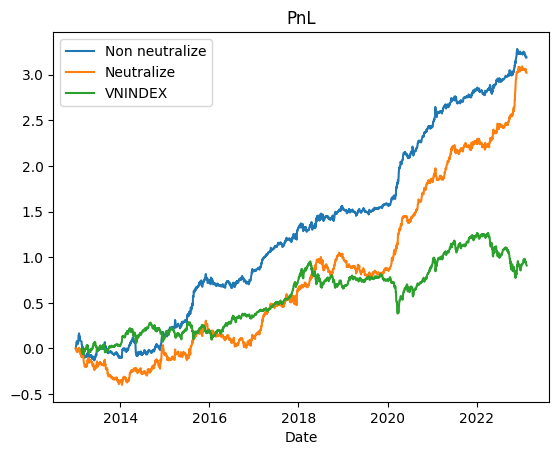

In [4]:
w = weights(alpha4,neutrali=0)
w1 =weights(alpha4,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [5]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.31883,1.775482,1.331533,0.868801,239.445986


In [5]:
a.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.098033,-0.529439,1.276389,-0.146727,-76.804928
2014,0.229845,1.309484,1.287131,0.553358,178.571520
2015,0.622227,2.969580,1.243514,2.100604,500.378276
2016,0.103313,0.649422,1.295763,0.183375,79.731055
2017,0.476558,3.319054,1.246933,2.051873,382.183888
2018,0.210365,0.961280,1.371960,0.376414,153.331701
2019,0.056355,0.513905,1.415318,0.102547,39.817988
2020,0.842759,4.331601,1.320395,3.460574,638.262681
2021,0.411932,2.371984,1.389048,1.291712,296.556870


In [6]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.301959,1.411115,2.430707,0.497359,124.226695


In [6]:
b.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.359061,-1.754053,2.312435,-0.691181,-155.274046
2014,0.299167,1.430793,2.311373,0.514753,129.432677
2015,0.249485,0.983844,2.235507,0.328670,111.600973
2016,-0.066890,-0.354102,2.317505,-0.060159,-28.863083
2017,0.535188,2.388655,2.274992,1.158555,235.248277
2018,0.345574,1.514616,2.504258,0.562643,137.994389
2019,-0.122001,-0.746167,2.611006,-0.161292,-46.725579
2020,0.971639,4.840022,2.391936,3.084786,406.214363
2021,0.402777,1.950924,2.588527,0.769566,155.600646


In [20]:
a=ts_sum(1*(open>close),20)/ts_sum(1*(open<close),20)
b=ts_sum(1*(open>close),250)/ts_sum(1*(open<close),250)
alpha6=rank(a/b)

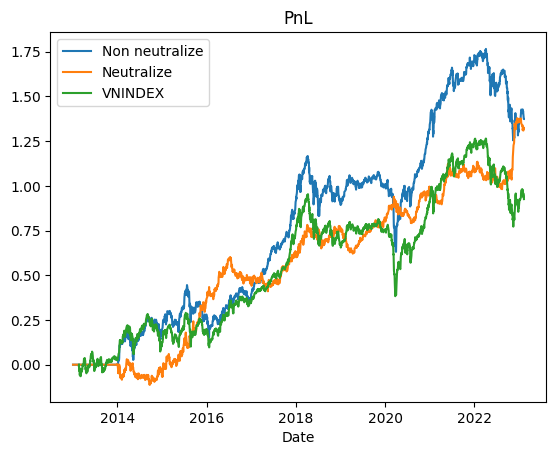

In [21]:
w =weights(alpha6, neutrali=0)
w1 =-1*weights(alpha6,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [22]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.137306,0.704386,0.121601,0.748492,1129.154626


In [23]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.132059,0.910868,0.501322,0.467499,263.420573


### alpha2=ts_zscore(close,2)

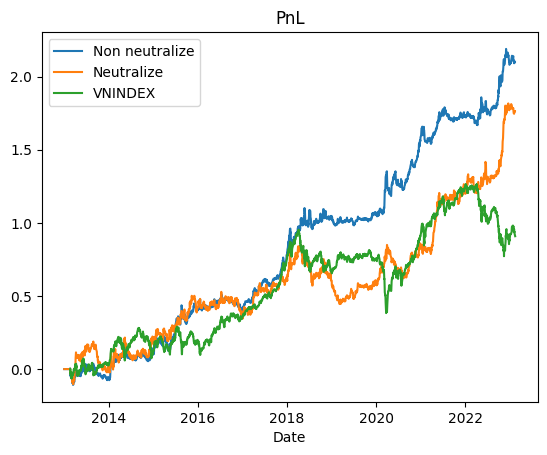

In [25]:
alpha7 = ts_zscore(close,30)
w =weights(alpha7, neutrali=0)
w1 =weights(alpha7,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [17]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.21108,1.233284,0.331917,0.983494,635.941938


In [8]:
a.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.064092,-0.517941,0.334364,-0.226763,-191.683652
2014,0.164754,0.994317,0.348389,0.683772,472.903536
2015,0.308903,1.723217,0.329832,1.667650,936.547681
2016,0.000275,0.002131,0.357286,0.000059,0.769122
2017,0.381386,3.450567,0.326877,3.727181,1166.756143
2018,0.250554,1.128692,0.307966,1.018062,813.575715
2019,0.037460,0.418835,0.331373,0.140820,113.043539
2020,0.518872,2.332487,0.301202,3.061403,1722.672814
2021,0.142905,0.861529,0.335424,0.562337,426.043487


In [9]:
w.iloc[-1,:].sort_values(ascending=False)

VCB    0.043158
SAB    0.037744
BID    0.033565
HDB    0.031564
PLX    0.029452
GAS    0.018974
BCM    0.017420
CTG    0.005394
FPT    0.003142
HPG    0.002381
TPB    0.001542
VRE    0.000596
POW    0.000104
BVH   -0.003832
ACB   -0.004756
STB   -0.008094
VIB   -0.012742
MBB   -0.020338
SSI   -0.031250
MWG   -0.031469
MSN   -0.035352
TCB   -0.039177
GVR   -0.042732
VIC   -0.050364
VNM   -0.054764
VJC   -0.074882
VHM   -0.078724
VPB   -0.081651
PDR   -0.096943
NVL   -0.107893
Name: 2023-02-13 00:00:00, dtype: float64

In [5]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.176338,0.916854,0.733388,0.449579,240.442761


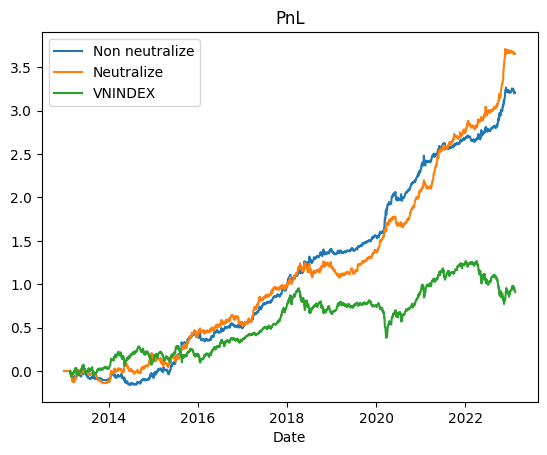

In [10]:
alpha = (0.3*alpha7+0.7*ts_zscore(close,2))
w =weights(alpha, neutrali=0)
w1 =weights(alpha,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

m=get_index_series(index_code='VNINDEX', time_range='TenYears')
m["i"]=pd.to_datetime(m["tradingDate"])
plt.plot(m["i"],np.cumsum(m["indexValue"].pct_change()), label="VNINDEX")
plt.legend()

In [27]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.32117,2.053349,0.822078,1.283435,390.680698


In [11]:
a.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.098675,-0.999891,0.294665,-0.578618,-334.872133
2014,0.021326,0.159988,0.536806,0.031888,39.727162
2015,0.486856,3.053574,0.773049,2.423288,629.786208
2016,0.093690,0.721912,0.772538,0.251403,121.275226
2017,0.487511,4.813249,0.907573,3.527682,537.158267
2018,0.402199,1.935975,0.942051,1.264979,426.940003
2019,0.177017,2.068106,0.918968,0.907673,192.625383
2020,0.764383,3.721113,0.949928,3.337976,804.675310
2021,0.362637,2.186176,0.992600,1.321399,365.340680


In [26]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.366223,2.032604,1.605508,0.970777,228.104246


In [12]:
b.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.121297,-0.949902,0.446985,-0.494832,-271.367943
2014,0.253428,1.372207,0.896481,0.729586,282.692388
2015,0.281357,1.337242,1.430049,0.593149,196.746631
2016,0.123436,0.760595,1.348991,0.230075,91.502520
2017,0.462440,2.977805,1.853925,1.487229,249.438360
2018,0.212957,0.917527,1.906243,0.306673,111.715520
2019,0.189158,1.486469,1.874284,0.472227,100.922833
2020,0.697736,4.367199,1.952334,2.610786,357.385357
2021,0.660119,3.606624,1.970252,2.087619,335.043017


In [13]:
w.iloc[-1,:].sort_values(ascending=False)

SAB    0.044498
BID    0.042673
CTG    0.030369
VRE    0.028274
STB    0.024479
MWG    0.014270
MSN    0.012574
VJC   -0.004690
VCB   -0.009165
HDB   -0.014229
PLX   -0.015151
GAS   -0.019727
BCM   -0.020406
HPG   -0.026974
TPB   -0.027341
POW   -0.027969
BVH   -0.029688
ACB   -0.030091
VIB   -0.033579
MBB   -0.036896
SSI   -0.041662
TCB   -0.045124
GVR   -0.046676
VIC   -0.050010
VNM   -0.051931
VHM   -0.062395
VPB   -0.063674
PDR   -0.070352
NVL   -0.075134
FPT         NaN
Name: 2023-02-13 00:00:00, dtype: float64

In [33]:
save_weights(w,x)

## Q learning

In [41]:
import numpy as np
import pandas as pd
import random

# Load the time series data into a pandas DataFrame
data = close

# Define the Q-Learning algorithm
def q_learning(data, n_actions, alpha, gamma, epsilon, max_steps):
    # Initialize the Q-table with zeros
    Q = np.zeros((data.shape[0], n_actions))

    for i in range(max_steps):
        # Initialize the state
        state = np.random.randint(0, data.shape[0])
        
        # Choose an action using epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = np.random.choice(n_actions)
        else:
            action = np.argmax(Q[state, :])

        next_state = state + 1
        # Get the next state and reward based on the action
        if next_state == len(close):
            next_state = np.random.randint(0,len(close))
            reward = 0
        else:    
            reward = data.iloc[next_state, action] - data.iloc[state, action]
        
        # Update the Q-table using Bellman equation
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]))
    
    return Q

# Define the number of actions (i.e., the number of stocks to invest in)
n_actions = 30

# Define the learning rate, discount factor, and exploration rate
alpha = 0.1
gamma = 0.9
epsilon = 0.1

# Define the number of steps
max_steps = 100000

# Run the Q-Learning algorithm
Q = q_learning(data, n_actions, alpha, gamma, epsilon, max_steps)

df = pd.DataFrame(Q)

In [46]:
weights=df.div(df.abs().sum(axis=1),axis=0)
weights.columns = ticket
weights.index = close.index

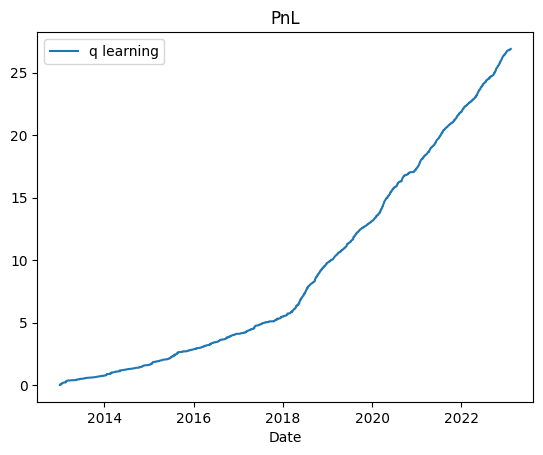

In [47]:
a = Simresult(weights,close.pct_change())
a.plot_pnl("q learning")

In [48]:
a.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,0.773968,6.460941,0.064721,16.076898,11958.554364
2014,0.872495,7.231508,0.119713,19.105361,7288.225908
2015,1.253939,7.288349,0.085290,23.084068,14702.028784
2016,1.257116,8.700565,0.124208,27.591801,10121.034219
2017,1.377069,6.828175,0.130227,22.204080,10574.411802
2018,4.326821,14.200458,1.235858,26.570670,3501.065946
2019,3.394455,15.632685,1.694747,22.124127,2002.926915
2020,4.231992,14.073931,1.323556,25.166140,3197.439847
2021,4.569020,18.941651,1.659955,31.425425,2752.495911


In [49]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,2.689725,11.166385,0.815207,20.283014,3299.436631
